# Telecom Churn Prediction

Interconnect, a telecom operator, aims to proactively identify customers at risk of leaving in order to offer them personalized retention strategies such as promotional codes or alternative plans. The company offers landline and internet services, along with optional add-ons like tech support, internet security, cloud storage, and streaming content. Customers can choose between monthly payments or long-term contracts, and use a variety of billing methods.

In this project, we use customer demographics, service usage patterns, and contract details to train a predictive model that forecasts churn. The data was collected from multiple sources—covering contracts, internet and phone services, and personal customer information—as of February 1, 2020.

The main objective is to build a machine learning model that accurately identifies which clients are likely to cancel their service. Our primary success metric is AUC-ROC, with a target of at least 0.88 to meet the highest performance standards. By surfacing key churn indicators through model interpretability and feature engineering, this project provides actionable insights to support Interconnect's customer retention efforts.

In [36]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.utils import resample

In [4]:
# Create file paths
contract_path = "/Users/sabrinamcfield/Data_Science_Projects-TripleTen-/project2_churn_prediction/final_provider/contract.csv"
personal_path = "/Users/sabrinamcfield/Data_Science_Projects-TripleTen-/project2_churn_prediction/final_provider/personal.csv"
internet_path = "/Users/sabrinamcfield/Data_Science_Projects-TripleTen-/project2_churn_prediction/final_provider/internet.csv"
phone_path = "/Users/sabrinamcfield/Data_Science_Projects-TripleTen-/project2_churn_prediction/final_provider/phone.csv"

# Load datasets
contract_df = pd.read_csv(contract_path)
personal_df = pd.read_csv(personal_path)
internet_df = pd.read_csv(internet_path)
phone_df = pd.read_csv(phone_path)

# Preprocessing

Clean data to prepare for modeling.

In [5]:
# === Merge Datasets ===
merged_df = contract_df.merge(personal_df, on='customerID', how='left') \
                       .merge(phone_df, on='customerID', how='left') \
                       .merge(internet_df, on='customerID', how='left')

In [6]:
# Get a general overview of the merged dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


In [7]:
merged_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [8]:
# Function to convert CamelCase or PascalCase to snake_case
def camel_to_snake(name):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()

# Apply it to all column names
merged_df.columns = [camel_to_snake(col) for col in merged_df.columns]

In [9]:
# Check changes applied
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

In [10]:
# Correct two column formats
merged_df.rename(columns={
    'customer_i_d': 'customer_id',
    'streaming_t_v': 'streaming_tv'
}, inplace=True)

In [11]:
# Apply transformation only to object (string) columns
for col in merged_df.select_dtypes(include='object').columns:
    merged_df[col] = merged_df[col].str.strip().str.lower().str.replace(' ', '_')

# Check changes applied
merged_df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic_check,29.85,29.85,female,0,yes,no,NaN,dsl,no,yes,no,no,no,no
1,5575-gnvde,2017-04-01,no,one_year,no,mailed_check,56.95,1889.5,male,0,no,no,no,dsl,yes,no,yes,no,no,no
2,3668-qpybk,2019-10-01,2019-12-01_00:00:00,month-to-month,yes,mailed_check,53.85,108.15,male,0,no,no,no,dsl,yes,yes,no,no,no,no
3,7795-cfocw,2016-05-01,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,male,0,no,no,NaN,dsl,yes,no,yes,yes,no,no
4,9237-hqitu,2019-09-01,2019-11-01_00:00:00,month-to-month,yes,electronic_check,70.70,151.65,female,0,no,no,no,fiber_optic,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-resvb,2018-02-01,no,one_year,yes,mailed_check,84.80,1990.5,male,0,yes,yes,yes,dsl,yes,no,yes,yes,yes,yes
7039,2234-xaduh,2014-02-01,no,one_year,yes,credit_card_(automatic),103.20,7362.9,female,0,yes,yes,yes,fiber_optic,no,yes,yes,no,yes,yes
7040,4801-jzazl,2019-03-01,no,month-to-month,yes,electronic_check,29.60,346.45,female,0,yes,yes,NaN,dsl,yes,no,no,no,no,no
7041,8361-ltmkd,2019-07-01,2019-11-01_00:00:00,month-to-month,yes,mailed_check,74.40,306.6,male,1,yes,no,yes,fiber_optic,no,no,no,no,no,no


In [12]:
# List of columns to fill
internet_service_cols = [
    'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'
]

# Fill missing values with 'no_internet_service'
merged_df[internet_service_cols] = merged_df[internet_service_cols].fillna('no_internet_service')

In [13]:
# Fill missing values with 'no_phone_service'
merged_df['multiple_lines'] = merged_df['multiple_lines'].fillna('no_phone_service')

In [14]:
# Convert 'begin_date' column to datetime format
merged_df['begin_date'] = pd.to_datetime(merged_df['begin_date'], errors='coerce')

In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

In [16]:
# Convert 'total_charges' column into a float64 type
merged_df['total_charges'] = pd.to_numeric(merged_df['total_charges'], errors='coerce')

### Preprocessing Summary

To prepare the data for modeling, I began by merging all four original datasets into a single DataFrame called merged_df. I then cleaned up the column names by converting them from camel case to snake case and lowercasing them for consistency. In addition, I standardized all object-type columns by making their values lowercase and replacing any spaces with underscores, making the dataset more uniform and easier to work with programmatically.

The begin_date column was converted to datetime format so it could be used in time-based calculations, such as determining customer tenure. For service-related columns like internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, and streaming_movies, I filled missing values with 'no_internet_service'. This approach preserves the distinction between customers who are ineligible for these services due to not having internet, and those who simply opted out. Similarly, I filled missing values in the multiple_lines column with 'no_phone_service', to clearly separate those without phone service from those who just don’t have multiple lines.

These steps ensure the data is clean, consistent, and ready for reliable analysis and model training, while preserving meaningful differences in customer access to services.

# Feature Engineering

Prepare the data to bring more clarity during visualizations and for optimizing it to produce the best results during training.

### Target Creation

In [17]:
# Create a target variable where 'no' or 0 = has not churned and 'date' or 1 = has churned
merged_df['churn'] = merged_df['end_date'].apply(lambda x: 0 if x == 'no' else 1)

### Feature Creation

In [18]:
# Define the cutoff date (e.g., data snapshot date)
cutoff_date = pd.to_datetime('2020-02-01')

# Calculate tenure in months and create a new column
merged_df['tenure_months'] = ((cutoff_date - merged_df['begin_date']).dt.days // 30).astype(int)

In [19]:
# Create a long_term_contract column that excludes month-to-month contracts( 0 =  month to month, 1 = one and two year)
merged_df['long_term_contract'] = merged_df['type'].apply(lambda x: 0 if x == 'month-to-month' else 1)

In [20]:
# Create an new feature for internet and tv
merged_df['internet_tv_combo'] = merged_df['internet_service'] + '_' + merged_df['streaming_tv']

In [21]:
# Create a new feature for contract type and tech support
merged_df['contract_support_combo'] = merged_df['type'].astype(str) + '_' + merged_df['tech_support'].astype(str)

In [22]:
# Create new feature to represent average monthly charges
merged_df['total_charges'] = pd.to_numeric(merged_df['total_charges'], errors='coerce')
merged_df['avg_monthly_charge'] = (merged_df['total_charges'] / merged_df['tenure_months']).fillna(0)

In [23]:
# Define service columns
service_cols = ['online_security', 'online_backup', 'tech_support', 'streaming_tv', 'streaming_movies']

# Create a new feature to count services
merged_df['service_count'] = merged_df[service_cols].apply(lambda row: sum(val == 'yes' for val in row), axis=1)

In [24]:
# Create a new feature for charges per service
merged_df['charge_per_service'] = merged_df['monthly_charges'] / merged_df['service_count'].replace(0, 1)

In [25]:
# View the changes
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             7043 non-null   object        
 1   begin_date              7043 non-null   datetime64[ns]
 2   end_date                7043 non-null   object        
 3   type                    7043 non-null   object        
 4   paperless_billing       7043 non-null   object        
 5   payment_method          7043 non-null   object        
 6   monthly_charges         7043 non-null   float64       
 7   total_charges           7032 non-null   float64       
 8   gender                  7043 non-null   object        
 9   senior_citizen          7043 non-null   int64         
 10  partner                 7043 non-null   object        
 11  dependents              7043 non-null   object        
 12  multiple_lines          7043 non-null   object  

### Encoding

In [26]:
# Make a copy of the original DataFrame before encoding
merged_df_encoded = merged_df.copy()

# Binary columns (Yes/No → 1/0)
binary_cols = ['partner', 'dependents', 'paperless_billing']

for col in binary_cols:
    merged_df_encoded[col] = merged_df_encoded[col].map({'yes': 1, 'no': 0})

In [27]:
# Gender: binary as well
merged_df_encoded['gender'] = merged_df_encoded['gender'].map({'female': 0, 'male': 1})

# Contract Type: ordinal encoding
contract_map = {'month-to-month': 0, 'one_year': 1, 'two_year': 2}
merged_df_encoded['contract_type'] = merged_df_encoded['type'].map(contract_map)

# Drop 'customer_id' column
merged_df_encoded.drop(columns=['customer_id', 'end_date'], inplace=True)

In [28]:
merged_df_encoded.dtypes[merged_df_encoded.dtypes == 'object']

type                      object
payment_method            object
multiple_lines            object
internet_service          object
online_security           object
online_backup             object
device_protection         object
tech_support              object
streaming_tv              object
streaming_movies          object
internet_tv_combo         object
contract_support_combo    object
dtype: object

In [29]:
# Convert 'yes'/'no' to 1/0
merged_df_encoded = merged_df_encoded.replace({'yes': 1, 'no': 0})

In [38]:
label_enc = LabelEncoder()
for col in merged_df_encoded.columns:
    if merged_df_encoded[col].dtype == 'object' or merged_df_encoded[col].apply(type).nunique() > 1:
        merged_df_encoded[col] = label_enc.fit_transform(merged_df_encoded[col].astype(str))

In [30]:
merged_df_encoded

,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,...,streaming_movies,churn,tenure_months,long_term_contract,internet_tv_combo,contract_support_combo,avg_monthly_charge,service_count,charge_per_service,contract_type
0,2020-01-01,month-to-month,1,electronic_check,29.85,29.85,0,0,1,0,...,0,0,1,0,dsl_no,month-to-month_no,29.850000,1,29.8500,0
1,2017-04-01,one_year,0,mailed_check,56.95,1889.50,1,0,0,0,...,0,0,34,1,dsl_no,one_year_no,55.573529,1,56.9500,1
2,2019-10-01,month-to-month,1,mailed_check,53.85,108.15,1,0,0,0,...,0,1,4,0,dsl_no,month-to-month_no,27.037500,2,26.9250,0
3,2016-05-01,one_year,0,bank_transfer_(automatic),42.30,1840.75,1,0,0,0,...,0,0,45,1,dsl_no,one_year_yes,40.905556,2,21.1500,1
4,2019-09-01,month-to-month,1,electronic_check,70.70,151.65,0,0,0,0,...,0,1,5,0,fiber_optic_no,month-to-month_no,30.330000,0,70.7000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2018-02-01,one_year,1,mailed_check,84.80,1990.50,1,0,1,1,...,1,0,24,1,dsl_yes,one_year_yes,82.937500,4,21.2000,1
7039,2014-02-01,one_year,1,credit_card_(automatic),103.20,7362.90,0,0,1,1,...,1,0,73,1,fiber_optic_yes,one_year_no,100.861644,3,34.4000,1
7040,2019-03-01,month-to-month,1,electronic_check,29.60,346.45,0,0,1,1,...,0,0,11,0,dsl_no,month-to-month_no,31.495455,1,29.6000,0
7041,2019-07-01,month-to-month,1,mailed_check,74.40,306.60,1,1,1,0,...,0,1,7,0,fiber_optic_no,month-to-month_no,43.800000,0,74.4000,0


### Feature Engineering Summary

As part of the feature engineering process, I created a new target variable called churn to represent whether a customer has left the company. Customers with 'no' in the original end_date column were labeled as 0 (still active), while those with an actual date were labeled as 1 (churned).

To capture customer loyalty over time, I calculated each customer's tenure in months and added a new column called tenure_months, measuring the length of their relationship with the company. I also created a long_term_contract column to highlight commitment levels, where customers with month-to-month contracts were labeled as 0 and those with one- or two-year contracts were labeled as 1.

Overall, I created the following new columns; churn, tenure_months, long_term_contract, internet_tv_combo, contract_support_combo, avg_monthly_charge, service_count and charge_per_service. This highlightes nuance relationships.

For modeling purposes, I applied two types of encoding. The first, stored in merged_df_ohe, uses one-hot encoding and is optimized for logistic regression models. The second, stored in merged_df_encoded, uses label encoding and is designed for use with tree-based models such as Random Forest, XGBoost, and LightGBM. This dual approach ensures that the data is properly formatted and tailored to the specific needs of each algorithm.

# Visualizations

### Churn Class Distribution

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


/var/folders/rl/4f5pmhb97r921h_zb82l97q80000gn/T/ipykernel_12541/479800987.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='churn', palette=['skyblue', 'salmon'])


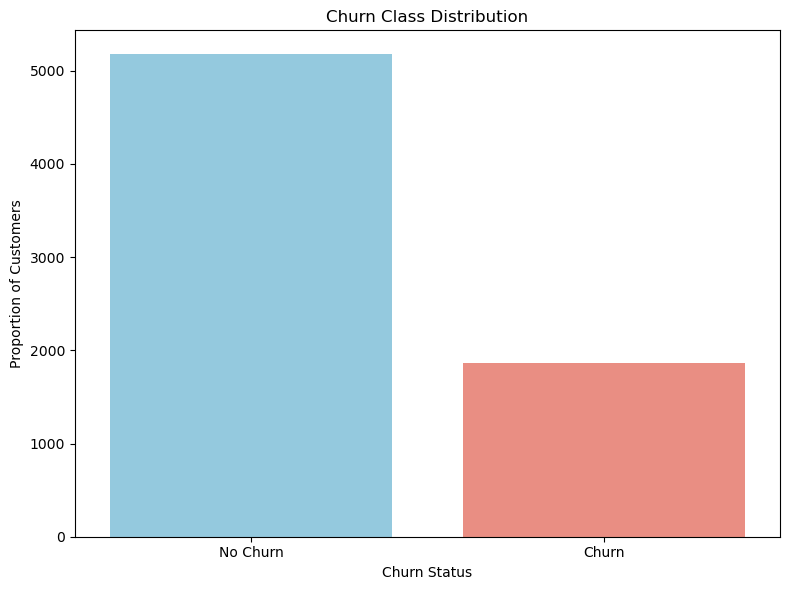

In [31]:
# Value counts
churn_counts = merged_df['churn'].value_counts(normalize=True)
print(churn_counts)

# Plot churn distribution with seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_df, x='churn', palette=['skyblue', 'salmon'])

# Plot
plt.title('Churn Class Distribution')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.xlabel('Churn Status')
plt.ylabel('Proportion of Customers')
plt.tight_layout()
plt.show()


This chart shows there's a noticeable lean in the data—most customers, around 73%, chose to stay, while only 27% decided to leave. This kind of imbalance isn’t drastic, but it’s enough to potentially throw off the model. Since the majority of people didn’t churn, the model might start to assume most future customers won’t either. That can be a problem because our main goal is to spot the ones who actually are at risk of leaving.

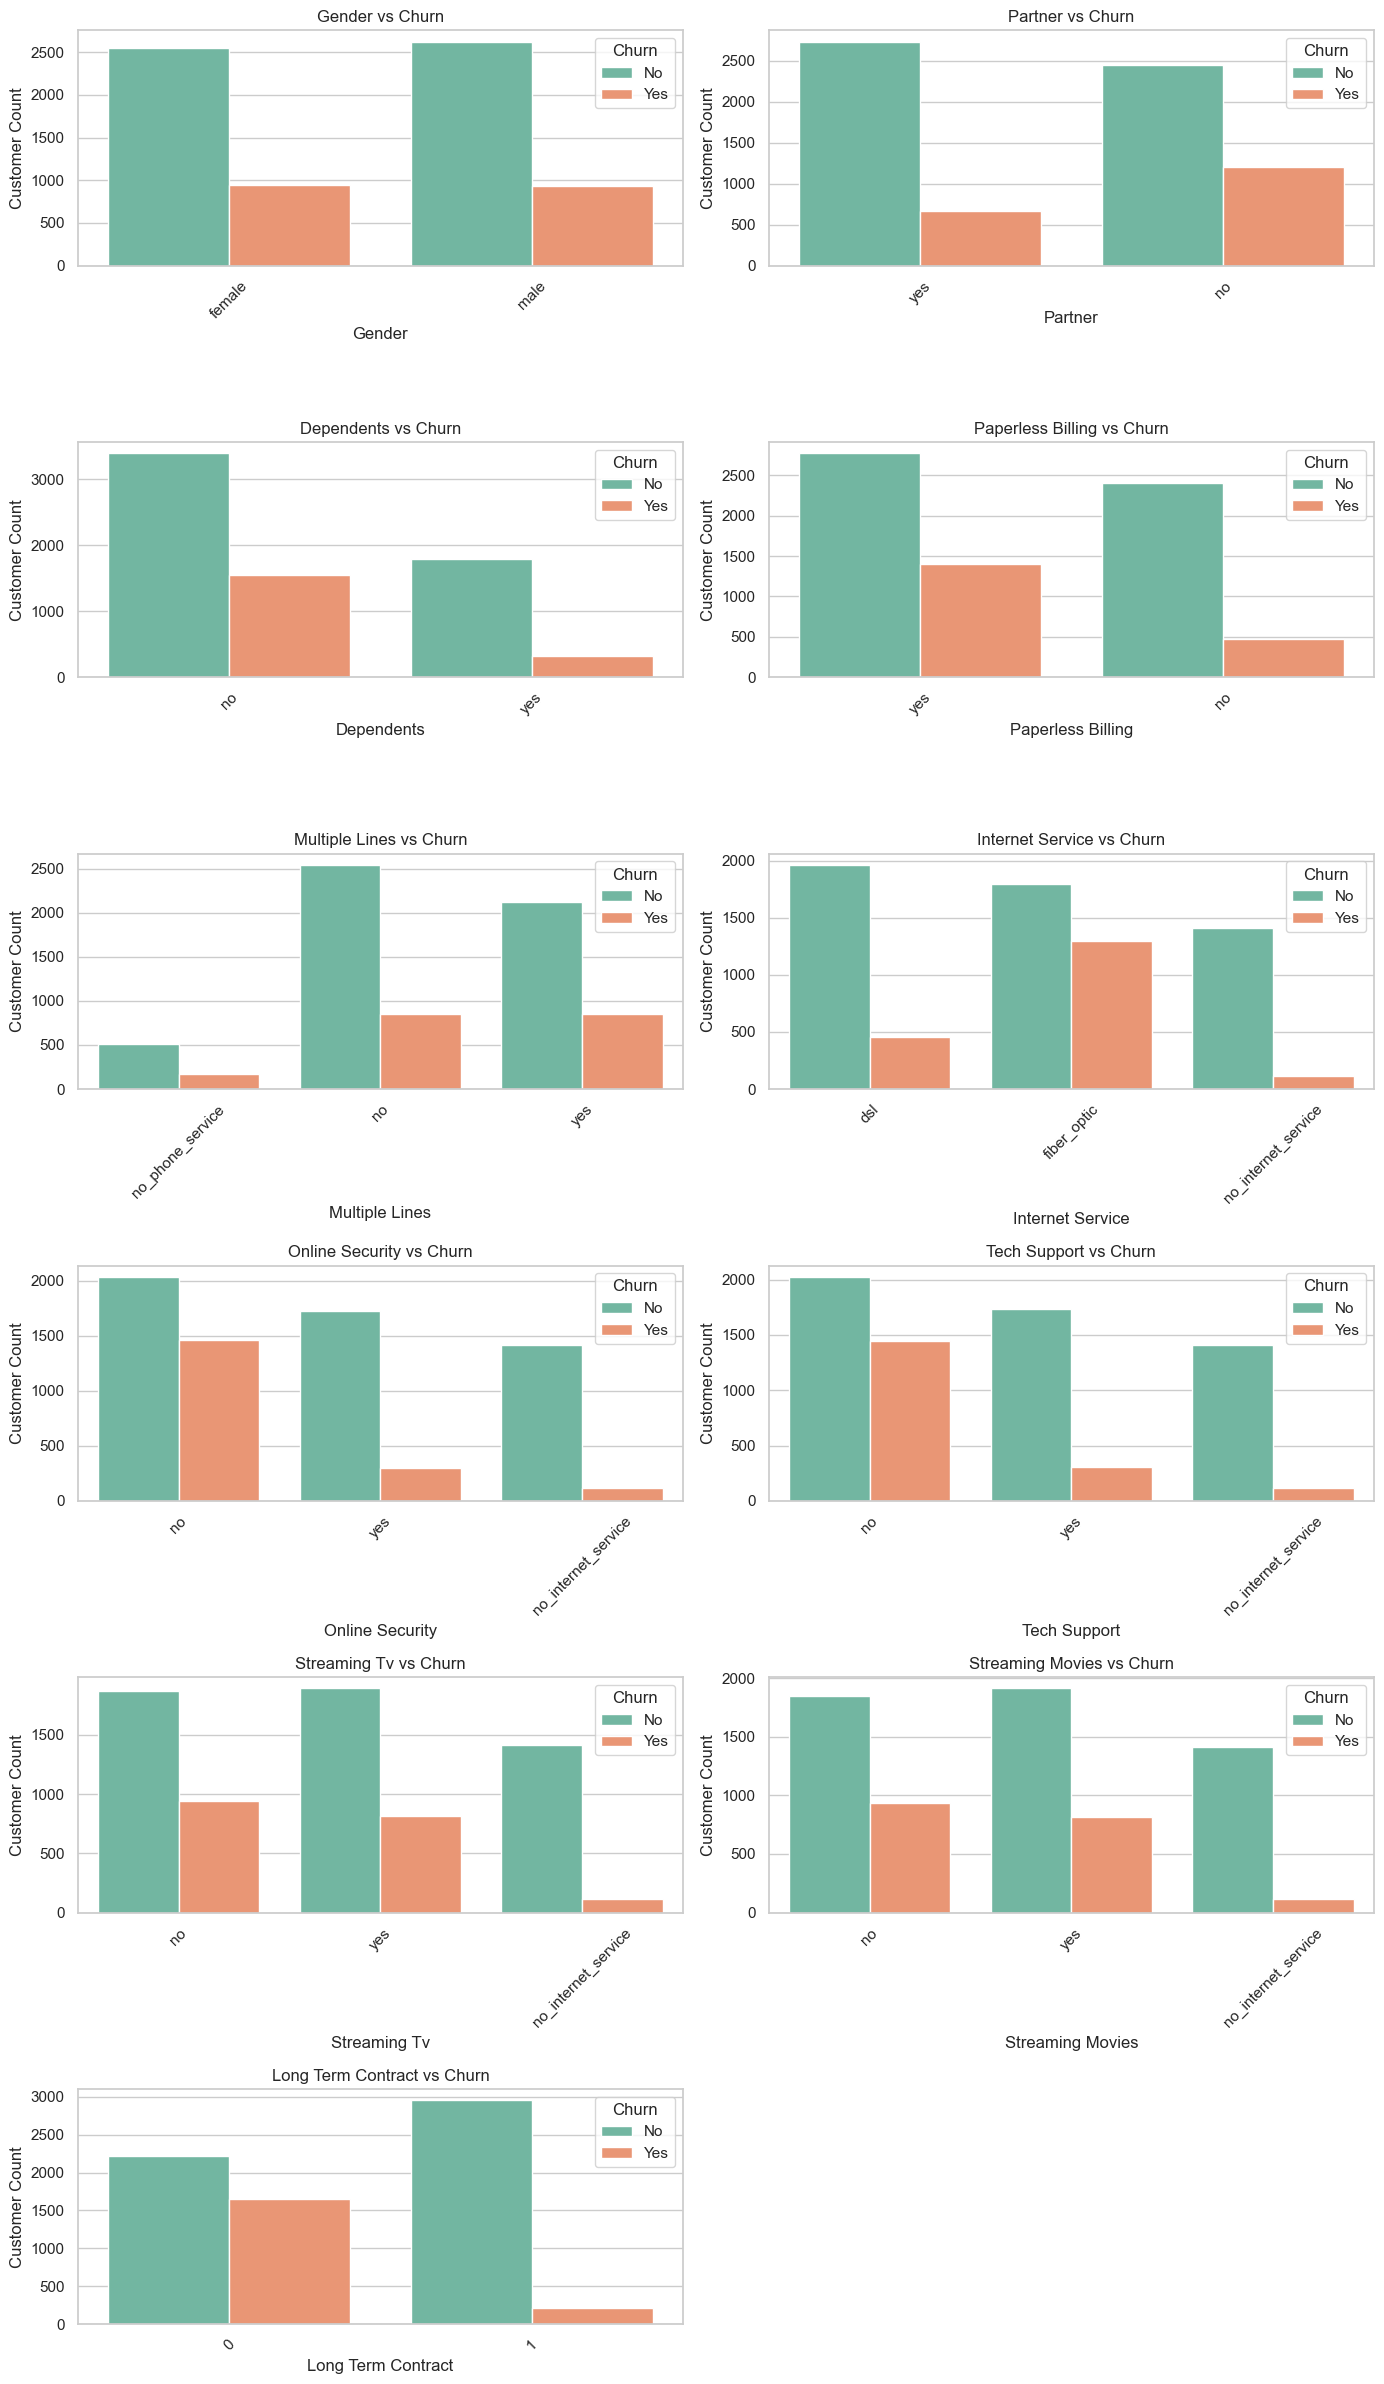

In [32]:
# Set visual style
sns.set(style='whitegrid')

# List of selected categorical features
categorical_features = ['gender', 'partner', 'dependents', 'paperless_billing',
                        'multiple_lines', 'internet_service', 'online_security',
                        'tech_support', 'streaming_tv', 'streaming_movies', 'long_term_contract']  

# Set number of rows needed (2 columns per row)
n_cols = 2
n_rows = (len(categorical_features) + 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()  # Flatten in case it's 2D

# Loop through features and plot
for i, col in enumerate(categorical_features):
    sns.countplot(data=merged_df, x=col, hue='churn', palette='Set2', ax=axes[i])
    axes[i].set_title(f'{col.replace("_", " ").title()} vs Churn')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel('Customer Count')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Churn', labels=['No', 'Yes'])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The churn analysis reveals that customers with stronger service engagement and longer-term commitments are less likely to leave, while those with fewer ties or minimal usage are more likely to churn. Contract type stands out as the most influential factor—customers on month-to-month plans churn significantly more than those with one- or two-year contracts. Support features like tech support and online security also play a major role in retention, with users of these services showing much lower churn rates. Fiber optic internet users tend to churn more than DSL users, possibly due to higher performance expectations. Additionally, customers without partners or dependents are more likely to leave, suggesting that personal responsibilities may contribute to loyalty. Paperless billing users also show slightly higher churn, likely reflecting digital-savvy customers who are more open to switching providers. Overall, customers with bundled services, family connections, and long-term plans are the least likely to churn.

### Numerical Features vs. Churn

/var/folders/rl/4f5pmhb97r921h_zb82l97q80000gn/T/ipykernel_12541/2557747021.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=merged_df[merged_df['churn'] == 0], x=col, label='No Churn', shade=True, ax=axes[i])
/var/folders/rl/4f5pmhb97r921h_zb82l97q80000gn/T/ipykernel_12541/2557747021.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=merged_df[merged_df['churn'] == 1], x=col, label='Churn', shade=True, ax=axes[i])
/var/folders/rl/4f5pmhb97r921h_zb82l97q80000gn/T/ipykernel_12541/2557747021.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=merged_df[merged_df['churn'] == 0], x=col, label='No Churn'

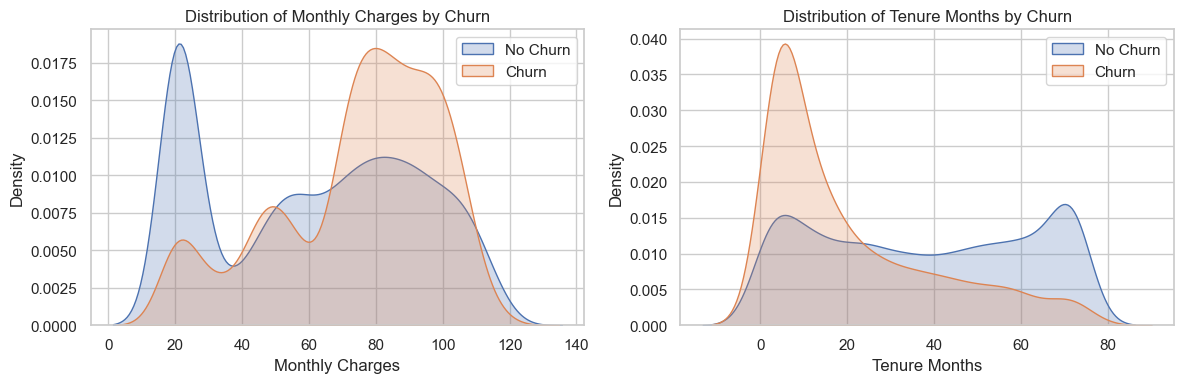

In [33]:
# Set visual style
sns.set(style='whitegrid')

# List of numerical features
numerical_features = ['monthly_charges', 'tenure_months']

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loop through features and plot
for i, col in enumerate(numerical_features):
    sns.kdeplot(data=merged_df[merged_df['churn'] == 0], x=col, label='No Churn', shade=True, ax=axes[i])
    sns.kdeplot(data=merged_df[merged_df['churn'] == 1], x=col, label='Churn', shade=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col.replace("_", " ").title()} by Churn')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()

These charts tell a pretty relatable story about customer behavior. Looking at monthly charges, the pattern is clear—people who end up leaving tend to be the ones paying the most. Their bills often land in the $80 to $90 range, while those who stick around usually pay much less, often under $30. It’s not hard to imagine that higher prices might make customers question whether they’re really getting their money’s worth.

When you look at how long customers stay, the difference is even more striking. Most people who churn do it early on—within their first year. But if someone makes it past those early months, they’re a lot more likely to stay for the long haul, sometimes for years. It’s like building a relationship: if it feels right in the beginning, there’s a good chance it will last.

Put simply, people tend to leave when the price feels too high or the connection just doesn’t click early enough. Giving new customers more support and making the service feel valuable right away could make a real difference in keeping them around.

### Feature Correlation to Churn Heat Map

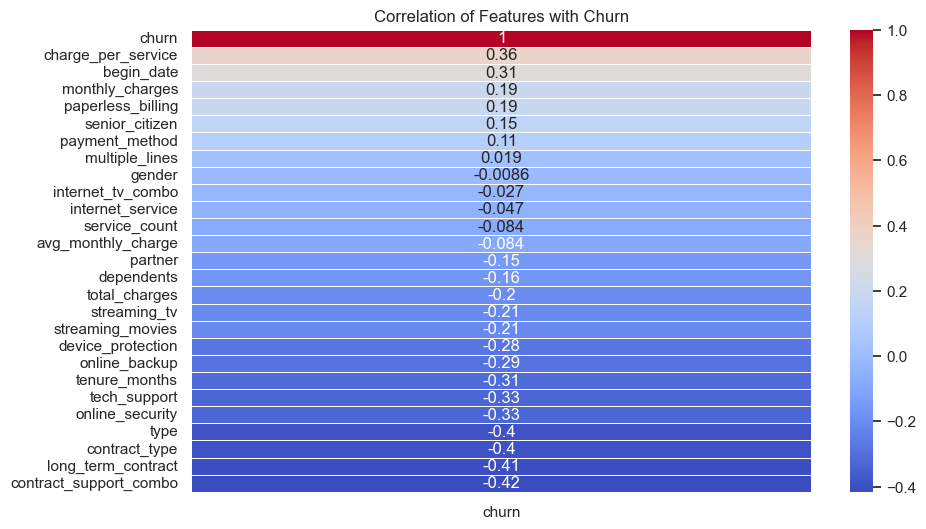

In [40]:
# Calculate correlation with churn
corr_matrix = merged_df_encoded.corr()

# Visualize only correlation with churn
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[['churn']].sort_values(by='churn', ascending=False), 
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation of Features with Churn')
plt.show()

This heatmap confirms what was displayed in the distribution plots and helps us clarify which parts of a customer’s experience are tied to whether they stay or leave. Some features have a stronger pull—either keeping people loyal or nudging them toward the exit.

What really stands out is that customers with long-term contracts, online security, or tech support are much less likely to churn. These services seem to give people a sense of value and support, making them more likely to stick with the company. In other words, when customers feel taken care of or have committed to a longer plan, they’re not in a hurry to leave.

On the other hand, people with higher monthly bills, those using paperless billing, or older customers (as indicated by the senior_citizen feature) are a bit more likely to leave. While the link isn’t dramatic, it suggests that cost and convenience may push some folks to look elsewhere if they’re not happy.

Interestingly, some things like gender and having multiple lines don’t really affect churn either way. These factors seem pretty neutral.

So, the takeaway is that customers who have support and who are invested through contracts are the ones who stay. But if things get too expensive or impersonal, that’s when they become suseptible to leaving.

### Visualizations Summary

The visualizations reveal clear patterns in customer behavior and churn. Around 73% of customers stay, while 27% leave, showing a moderate class imbalance that could bias models toward predicting "no churn."

The most influential factor is contract type—customers on month-to-month plans churn far more than those on longer contracts. Services like tech support and online security also help retain customers, while higher monthly charges, paperless billing, and older age slightly increase the chance of churn.

Customers who churn often pay more (around $90) and tend to leave within the first year. In contrast, those who stay longer usually pay less and have longer, more stable relationships with the company.

The correlation heatmap backs this up: loyalty grows with longer contracts and helpful services, while churn risk rises with cost and minimal engagement. Overall, people stay when they are supported and committed, and leave when the service is too expensive or impersonal.

# Machine Learning

### Split Data for Modeling

In [41]:
#Drop unnecessary columns
merged_df.drop(columns=['customer_id', 'begin_date', 'end_date', 'type'], inplace=True)

In [42]:
# Check for duplicates
duplicates = merged_df[merged_df.duplicated()]
print(duplicates)

     paperless_billing    payment_method  monthly_charges  total_charges  \
1491                no      mailed_check            19.55          19.55   
1932                no      mailed_check            20.20          20.20   
2713               yes      mailed_check            20.45          20.45   
2892                no      mailed_check            20.45          20.45   
3301               yes  electronic_check            69.60          69.60   
3754                no      mailed_check            20.05          20.05   
5506                no      mailed_check            20.20          20.20   
5736                no      mailed_check            20.05          20.05   
6499                no      mailed_check            20.30          20.30   
6609               yes      mailed_check            20.10          20.10   
6706                no      mailed_check            19.90          19.90   
6774                no      mailed_check            19.65          19.65   
6924        

In [43]:
merged_df = merged_df.drop_duplicates()

In [44]:
pd.set_option('display.max_columns', None)
merged_df

,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,churn,tenure_months,long_term_contract,internet_tv_combo,contract_support_combo,avg_monthly_charge,service_count,charge_per_service
0,yes,electronic_check,29.85,29.85,female,0,yes,no,no_phone_service,dsl,no,yes,no,no,no,no,0,1,0,dsl_no,month-to-month_no,29.850000,1,29.8500
1,no,mailed_check,56.95,1889.50,male,0,no,no,no,dsl,yes,no,yes,no,no,no,0,34,1,dsl_no,one_year_no,55.573529,1,56.9500
2,yes,mailed_check,53.85,108.15,male,0,no,no,no,dsl,yes,yes,no,no,no,no,1,4,0,dsl_no,month-to-month_no,27.037500,2,26.9250
3,no,bank_transfer_(automatic),42.30,1840.75,male,0,no,no,no_phone_service,dsl,yes,no,yes,yes,no,no,0,45,1,dsl_no,one_year_yes,40.905556,2,21.1500
4,yes,electronic_check,70.70,151.65,female,0,no,no,no,fiber_optic,no,no,no,no,no,no,1,5,0,fiber_optic_no,month-to-month_no,30.330000,0,70.7000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,yes,mailed_check,84.80,1990.50,male,0,yes,yes,yes,dsl,yes,no,yes,yes,yes,yes,0,24,1,dsl_yes,one_year_yes,82.937500,4,21.2000
7039,yes,credit_card_(automatic),103.20,7362.90,female,0,yes,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,0,73,1,fiber_optic_yes,one_year_no,100.861644,3,34.4000
7040,yes,electronic_check,29.60,346.45,female,0,yes,yes,no_phone_service,dsl,yes,no,no,no,no,no,0,11,0,dsl_no,month-to-month_no,31.495455,1,29.6000
7041,yes,mailed_check,74.40,306.60,male,1,yes,no,yes,fiber_optic,no,no,no,no,no,no,1,7,0,fiber_optic_no,month-to-month_no,43.800000,0,74.4000


In [45]:
merged_df['total_charges'].isna().sum()

11

In [46]:
merged_df = merged_df.dropna(subset=['total_charges'])

In [47]:
merged_df['total_charges'].isna().sum()

0

In [48]:
# Prepare features and target of ohe data
X = merged_df.drop('churn', axis=1)
y = merged_df['churn']

# First split: 75% train, 25% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Second split: 15% val, 10% test from the 25% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42, stratify=y_temp)

### One Hot Encoding for Logistic Regression

In [51]:
# Select categorical features to encode
categorical_features = ['paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection',
                        'internet_tv_combo', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_support_combo']

# OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit on training data
X_train_cat = ohe.fit_transform(X_train[categorical_features])
X_val_cat = ohe.transform(X_val[categorical_features])
X_test_cat = ohe.transform(X_test[categorical_features])

# Get OHE feature names
ohe_columns = ohe.get_feature_names_out(categorical_features)

# Drop original categorical columns and reset index
X_train_num = X_train.drop(columns=categorical_features).reset_index(drop=True)
X_val_num = X_val.drop(columns=categorical_features).reset_index(drop=True)
X_test_num = X_test.drop(columns=categorical_features).reset_index(drop=True)

# Combine numeric + encoded categorical
X_train_encoded = pd.concat([X_train_num, pd.DataFrame(X_train_cat, columns=ohe_columns)], axis=1)
X_val_encoded = pd.concat([X_val_num, pd.DataFrame(X_val_cat, columns=ohe_columns)], axis=1)
X_test_encoded = pd.concat([X_test_num, pd.DataFrame(X_test_cat, columns=ohe_columns)], axis=1)

### Scaled, One Hot Encoding for Logistic Regression

In [52]:
# Scale data 
scaler = StandardScaler()

# Fit on training data and transform all sets
X_train_ohe_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_encoded),
    columns=X_train_encoded.columns,
    index=X_train_encoded.index
)

X_val_ohe_scaled = pd.DataFrame(
    scaler.transform(X_val_encoded),
    columns=X_val_encoded.columns,
    index=X_val_encoded.index
)

X_test_ohe_scaled = pd.DataFrame(
    scaler.transform(X_test_encoded),
    columns=X_test_encoded.columns,
    index=X_test_encoded.index
)

### Train Logistic Regression Model on balanced data

In [53]:
# Initialize model with class_weight balanced to handle class imbalance
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Fit the model to training data
log_model.fit(X_train_encoded, y_train)

# Predict on validation set
y_val_pred = log_model.predict(X_val_encoded)
y_val_proba = log_model.predict_proba(X_val_encoded)[:, 1]  # Probabilities for AUC

# Evaluate
accuracy = accuracy_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation AUC-ROC: {roc_auc:.4f}")

Validation Accuracy: 0.9373
Validation AUC-ROC: 0.9787


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Train Logistic Regression Model on scaled balanced data

In [54]:
# Initialize model with class_weight balanced to handle class imbalance
log_model_scaled = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Fit the model to scaled training data
log_model_scaled.fit(X_train_ohe_scaled, y_train)

# Predict on validation set
y_val_pred_scaled = log_model.predict(X_val_ohe_scaled)
y_val_proba_scaled = log_model.predict_proba(X_val_ohe_scaled)[:, 1]  # Probabilities for AUC

# Evaluate
accuracy = accuracy_score(y_val, y_val_pred_scaled)
roc_auc = roc_auc_score(y_val, y_val_proba_scaled)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation AUC-ROC: {roc_auc:.4f}")

Validation Accuracy: 0.6752
Validation AUC-ROC: 0.7915


### Hypertune Logistic Regression Model

In [55]:
# Define the hyperparameter grid
param_grid_log = {
    'C': [0.01, 0.1, 1, 10],              # Inverse of regularization strength
    'penalty': ['l1', 'l2'],              # Regularization type
    'solver': ['liblinear', 'saga', 'lbfgs']       # Solvers that support both l1 and l2
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=log_model,
                           param_grid=param_grid_log,
                           scoring='roc_auc',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Run the grid search
grid_search.fit(X_train_encoded, y_train)

# Best model and score
print("Best Parameters:", grid_search.best_params_)
print(f"Validation Accuracy: {accuracy:.4f}")
print("Best AUC-ROC Score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Validation Accuracy: 0.6752
Best AUC-ROC Score: 0.9733472072354934


### Ordinal Encoding for Tree Based Model

In [56]:
# Initialize the OrdinalEncoder with a fallback for unknown categories
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit on training categorical data
X_train_cat = ord_enc.fit_transform(X_train[categorical_features])
X_val_cat = ord_enc.transform(X_val[categorical_features])
X_test_cat = ord_enc.transform(X_test[categorical_features])

# Create DataFrames with column names preserved
X_train_cat_df = pd.DataFrame(X_train_cat, columns=categorical_features, index=X_train.index)
X_val_cat_df = pd.DataFrame(X_val_cat, columns=categorical_features, index=X_val.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=categorical_features, index=X_test.index)

# Drop original categorical columns
X_train_num = X_train.drop(columns=categorical_features)
X_val_num = X_val.drop(columns=categorical_features)
X_test_num = X_test.drop(columns=categorical_features)

# Combine numeric and ordinal-encoded categorical columns
X_train_ord_encoded = pd.concat([X_train_num.reset_index(drop=True), X_train_cat_df.reset_index(drop=True)], axis=1)
X_val_ord_encoded = pd.concat([X_val_num.reset_index(drop=True), X_val_cat_df.reset_index(drop=True)], axis=1)
X_test_ord_encoded = pd.concat([X_test_num.reset_index(drop=True), X_test_cat_df.reset_index(drop=True)], axis=1)

### Train a Random Forest Classifier using (class_weight='balanced') on ordinal encoded data

In [57]:
# Initialize model (class_weight optional if data is already balanced)
rf_model_bal = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model on ordinal-encoded balanced data
rf_model_bal.fit(X_train_ord_encoded, y_train)

# Predict on validation set
y_val_pred_bal = rf_model_bal.predict(X_val_ord_encoded)
y_val_proba_bal = rf_model_bal.predict_proba(X_val_ord_encoded)[:, 1]  # Get probability for AUC

# Evaluate
accuracy_bal = accuracy_score(y_val, y_val_pred_bal)
roc_auc_bal = roc_auc_score(y_val, y_val_proba_bal)

print(f"Validation Accuracy: {accuracy_bal:.4f}")
print(f"Validation AUC-ROC: {roc_auc_bal:.4f}")

Validation Accuracy: 0.9231
Validation AUC-ROC: 0.9606


### Hypertune Random Forest Classifier Model

In [58]:
# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [150, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

# Setup GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model_bal,
                              param_grid=param_grid_rf,
                              scoring='roc_auc',
                              cv=5,
                              n_jobs=-1,
                              verbose=2)

# Fit to balanced training data
grid_search_rf.fit(X_train_ord_encoded, y_train)

# Best model
best_rf = grid_search_rf.best_estimator_

# Predict on validation set
y_val_pred = best_rf.predict(X_val_ord_encoded)
y_val_proba = best_rf.predict_proba(X_val_ord_encoded)[:, 1]

# Evaluate
accuracy_tuned = accuracy_score(y_val, y_val_pred_bal)
roc_auc_tuned = roc_auc_score(y_val, y_val_proba_bal)

print("Best Parameters:", grid_search_rf.best_params_)
print(f"Validation Accuracy: {accuracy_tuned:.4f}")
print(f"Validation AUC-ROC: {roc_auc_tuned:.4f}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END 

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Validation Accuracy: 0.9231
Validation AUC-ROC: 0.9606


### CatBoost Encoding

I attempted to use 'import category_encoders as ce' for CatBoost encoding but Im restricted from uploading the library in this enviornment. So I found a way to manually replicate CatBoost-sytle target encoding.

In [59]:
X_train.columns

Index(['paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents',
       'multiple_lines', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'tenure_months', 'long_term_contract',
       'internet_tv_combo', 'contract_support_combo', 'avg_monthly_charge',
       'service_count', 'charge_per_service'],
      dtype='object')

In [60]:
# Temporarily merge y_train with X_train to access churn values
X_train_cb = X_train.copy()
X_train_cb['churn'] = y_train

# Copy validation and test sets
X_val_cb = X_val.copy()
X_test_cb = X_test.copy()

# Apply target mean encoding
for col in categorical_features:
    mean_encoded = X_train_cb.groupby(col)['churn'].mean()
    
    X_train_cb[col] = X_train_cb[col].map(mean_encoded)
    X_val_cb[col] = X_val_cb[col].map(mean_encoded)
    X_test_cb[col] = X_test_cb[col].map(mean_encoded)

    overall_mean = y_train.mean()
    X_val_cb[col].fillna(overall_mean, inplace=True)
    X_test_cb[col].fillna(overall_mean, inplace=True)

# Drop churn column again from training set
X_train_cb.drop('churn', axis=1, inplace=True)

/var/folders/rl/4f5pmhb97r921h_zb82l97q80000gn/T/ipykernel_12541/1336353005.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val_cb[col].fillna(overall_mean, inplace=True)
/var/folders/rl/4f5pmhb97r921h_zb82l97q80000gn/T/ipykernel_12541/1336353005.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

### Train a XGBoost Model on CatBoost encoding data

In [61]:
# Initialize the model
xgb_model_cb = XGBClassifier(use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42)

# Train the model on balanced data
xgb_model_cb.fit(X_train_cb, y_train)

# Predict on validation set
y_val_pred_xgb_cb = xgb_model_cb.predict(X_val_cb)
y_val_proba_xgb_cb = xgb_model_cb.predict_proba(X_val_cb)[:, 1]  # Get probability for AUC

# Evaluate
accuracy_xgb_cb = accuracy_score(y_val, y_val_pred_xgb_cb)
roc_auc_xgb_cb = roc_auc_score(y_val, y_val_proba_xgb_cb)

print(f"Validation Accuracy: {accuracy_xgb_cb:.4f}")
print(f"Validation AUC-ROC: {roc_auc_xgb_cb:.4f}")

Validation Accuracy: 0.9473
Validation AUC-ROC: 0.9766


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Train a XGBoost Model CatBoost encoded, balanced data

In [62]:
# Count negative (no churn = 0) and positive (churn = 1) classes
from collections import Counter

counter = Counter(y_train)
neg, pos = counter[0], counter[1]
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")

scale_pos_weight = 2.76


In [63]:
# Initialize the model
xgb_model_cb_bal = XGBClassifier(use_label_encoder=False,
                          eval_metric='logloss',
                          scale_pos_weight=scale,          # helps balance the positive class
                          random_state=42)

# Train the model on balanced data
xgb_model_cb_bal.fit(X_train_cb, y_train)

# Predict on validation set
y_val_pred_xgb_cb_bal = xgb_model_cb_bal.predict(X_val_cb)
y_val_proba_xgb_cb_bal = xgb_model_cb_bal.predict_proba(X_val_cb)[:, 1]  # Get probability for AUC

# Evaluate
accuracy_xgb_cb_bal = accuracy_score(y_val, y_val_pred_xgb_cb_bal)
roc_auc_xgb_cb_bal = roc_auc_score(y_val, y_val_proba_xgb_cb_bal)

print(f"Validation Accuracy: {accuracy_xgb_cb_bal:.4f}")
print(f"Validation AUC-ROC: {roc_auc_xgb_cb_bal:.4f}")

Validation Accuracy: 0.9402
Validation AUC-ROC: 0.9772


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Train XGBoost Model on CatBoost encoded data

In [64]:
# Define the hyperparameter grid
param_dist_tuned = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Randomized search
random_search_tuned = RandomizedSearchCV(estimator=xgb_model_cb,
                                   param_distributions=param_dist_tuned,
                                   n_iter=10,
                                   scoring='roc_auc',
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Fit to balanced training data
random_search_tuned.fit(X_train_cb, y_train)

# Get best model
best_xgb_tuned = random_search_tuned.best_estimator_

# Predict on validation set
y_val_pred_tuned = best_xgb_tuned.predict(X_val_cb)
y_val_proba_tuned = best_xgb_tuned.predict_proba(X_val_cb)[:, 1]

# Evaluate
accuracy_tuned = accuracy_score(y_val, y_val_pred_tuned)
roc_auc_tuned = roc_auc_score(y_val, y_val_proba_tuned)

print("Best Parameters:", random_search_tuned.best_params_)
print(f"Validation Accuracy: {accuracy_tuned:.4f}")
print(f"Validation AUC-ROC: {roc_auc_tuned:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] 

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.3s
[CV

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Train LightGBM Model on CatBoost encoded data

In [65]:
# Initialize the model
lgb_model_cb = LGBMClassifier(random_state=42)

# Train on balanced data
lgb_model_cb.fit(X_train_cb, y_train)

# Predict on validation set
y_val_pred_lgbm_cb = lgb_model_cb.predict(X_val_cb)
y_val_proba_lgbm_cb = lgb_model_cb.predict_proba(X_val_cb)[:, 1]  # Probabilities for AUC

# Evaluate
accuracy_lgbm_cb = accuracy_score(y_val, y_val_pred_lgbm_cb)
roc_auc_lgbm_cb = roc_auc_score(y_val, y_val_proba_lgbm_cb)

print(f"Validation Accuracy: {accuracy_lgbm_cb:.4f}")
print(f"Validation AUC-ROC: {roc_auc_lgbm_cb:.4f}")

[LightGBM] [Info] Number of positive: 1399, number of negative: 3865
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1171
[LightGBM] [Info] Number of data points in the train set: 5264, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265767 -> initscore=-1.016204
[LightGBM] [Info] Start training from score -1.016204
Validation Accuracy: 0.9530
Validation AUC-ROC: 0.9766


### Train LightGBM Model on CatBoost balanced data

In [66]:
# Initialize the model
lgb_model_cb_bal = LGBMClassifier(class_weight='balanced', random_state=42)

# Train on balanced data
lgb_model_cb_bal.fit(X_train_cb, y_train)

# Predict on validation set
y_val_pred_lgbm_cb_bal = lgb_model_cb_bal.predict(X_val_cb)
y_val_proba_lgbm_cb_bal = lgb_model_cb_bal.predict_proba(X_val_cb)[:, 1]  # Probabilities for AUC

# Evaluate
accuracy_lgbm_cb_bal = accuracy_score(y_val, y_val_pred_lgbm_cb_bal)
roc_auc_lgbm_cb_bal = roc_auc_score(y_val, y_val_proba_lgbm_cb_bal)

print(f"Validation Accuracy: {accuracy_lgbm_cb_bal:.4f}")
print(f"Validation AUC-ROC: {roc_auc_lgbm_cb_bal:.4f}")

[LightGBM] [Info] Number of positive: 1399, number of negative: 3865
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1171
[LightGBM] [Info] Number of data points in the train set: 5264, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Validation Accuracy: 0.9316
Validation AUC-ROC: 0.9749


### Hypertune LightGBM Model

In [67]:
# Parameter grid for randomized search
param_dist_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, -1],  # -1 means no limit
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# RandomizedSearchCV
random_search_lgb_tuned = RandomizedSearchCV(estimator=lgb_model_cb,
                                       param_distributions=param_dist_lgbm,
                                       n_iter=20,
                                       scoring='roc_auc',
                                       cv=5,
                                       verbose=2,
                                       random_state=42,
                                       n_jobs=-1)

# Fit to balanced training data
random_search_lgb_tuned.fit(X_train_cb, y_train)

# Best model
best_lgb_tuned = random_search_lgb_tuned.best_estimator_

# Predict on validation set
y_val_pred_cb_tuned = best_lgb_tuned.predict(X_val_cb)
y_val_proba_cb_tuned = best_lgb_tuned.predict_proba(X_val_cb)[:, 1]

# Evaluate
accuracy_cb_bal_tuned = accuracy_score(y_val, y_val_pred_cb_tuned)
roc_auc_cb_bal_tuned = roc_auc_score(y_val, y_val_proba_cb_tuned)

# Results
print("Best Parameters:", random_search_lgb_tuned.best_params_)
print(f"Validation Accuracy: {accuracy_cb_bal_tuned:.4f}")
print(f"Validation AUC-ROC: {roc_auc_cb_bal_tuned:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 1119, number of negative: 3092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1171
[LightGBM] [Info] Number of data points in the train set: 4211, number of used features: 23
[LightGBM] [Info] Number of positive: 1119, number of negative: 3092
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265733 -> initscore=-1.016383
[LightGBM] [Info] Number of positive: 1119, number of negative: 3092
[LightGBM] [Info] Start training from score -1.016383
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1171
[LightGBM] [Info] Number of data points in the tr

### Training Evaluation Results

**Logistic Regression using class_weight='balanced' on ohe data**

log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Validation Accuracy: 0.9373

Validation AUC-ROC: 0.9787

**Logistic Regression using class_weight='balanced' on ohe scaled data**

Validation Accuracy: 0.6795

Validation AUC-ROC: 0.7919

**Logistic Regression Tuned using balanced ohe data**

log_model_tuned = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, 'C'= 0.01, 'penalty'= l1, 'solver'= 'liblinear')

Validation Accuracy: 0.6795

Best AUC-ROC Score: 0.9542252407646975917

-----

**Random Forest Classifier on balanced ordinal encoded data**

rf_model_bal = RandomForestClassifier(class_weight='balanced', random_state=42)

Validation Accuracy: 0.9217

Validation AUC-ROC: 0.9597

**Tuned Random Forest Classifier on balanced ordinal encoded data**

rf_model_tuned = RandomForestClassifier(class_weight='balanced', random_state=42, 'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300)

Validation Accuracy: 0.9217

Validation AUC-ROC: 0.9597

-----

**XGBoost on CatBoost encoded data**

Validation Accuracy: 0.9430

Validation AUC-ROC: 0.9795

**XGBoost on balanced, CatBoost encoded data**

Validation Accuracy: 0.9373

Validation AUC-ROC: 0.9775

**Tuned XGBoost on CatBoost encoded data**

xgb_model_tuned = XGBClassifier(use_label_encoder=False, scale_pos_weight=scale, eval_metric='logloss','subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.6, random_state=42)

Validation Accuracy: 0.9416

Validation AUC-ROC: 0.9761

-----

**LightGBM on CatBoost data**

Validation Accuracy: 0.9530

Validation AUC-ROC: 0.9766

**LightGBM using CatBoost balanced data**

Validation Accuracy: 0.9316

Validation AUC-ROC: 0.9749

**Tuned LightGBM on upsampled data**

lgb_model_tuned = LGBMClassifier(class_weight='balanced', 'subsample': 1.0, 'num_leaves': 15, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.6, random_state=42)

Validation Accuracy: 0.9430

Validation AUC-ROC: 0.9771

### Training Evaluation Summary

Across all models tested, performance was strong, but a few clear leaders emerged. Logistic Regression using one-hot encoding with class weighting achieved the highest AUC-ROC score of 0.9787, with a solid 93.7% validation accuracy. This suggests it's the most effective model for distinguishing between customers who churn and those who don’t—exactly what we want for this project. Interestingly, tuning or scaling this model actually reduced performance, showing that its default setup worked best.

Random Forest models were consistent and dependable. Both the base and tuned versions using ordinal encoding hit 92.17% accuracy and 0.9597 AUC-ROC, showing they’re solid performers, even without extensive tuning.

XGBoost stood out with top-tier results. Using CatBoost encoding, it reached 94.3% accuracy and 0.9795 AUC-ROC without tuning. Even the tuned and balanced variations stayed close, making XGBoost a reliable, high-performing choice.

LightGBM also impressed, achieving the highest overall accuracy at 95.3% and an AUC-ROC of 0.9766. Tuning brought it close to XGBoost, with nearly identical performance.

In conclusion, Logistic Regression remains the top pick due to its superior AUC-ROC score, making it the best for churn detection. But XGBoost and LightGBM are excellent runners-up, offering both high accuracy and strong predictive power—ideal for real-world deployment or ensemble approaches.

## Test Logistic Regression Model

In [68]:
# Predict on test set
y_test_pred = log_model.predict(X_test_encoded)
y_test_proba = log_model.predict_proba(X_test_encoded)[:, 1]  # Probabilities for AUC

# Evaluate
accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation AUC-ROC: {roc_auc:.4f}")

Validation Accuracy: 0.9174
Validation AUC-ROC: 0.9754


## AUC-ROC Curve Plot

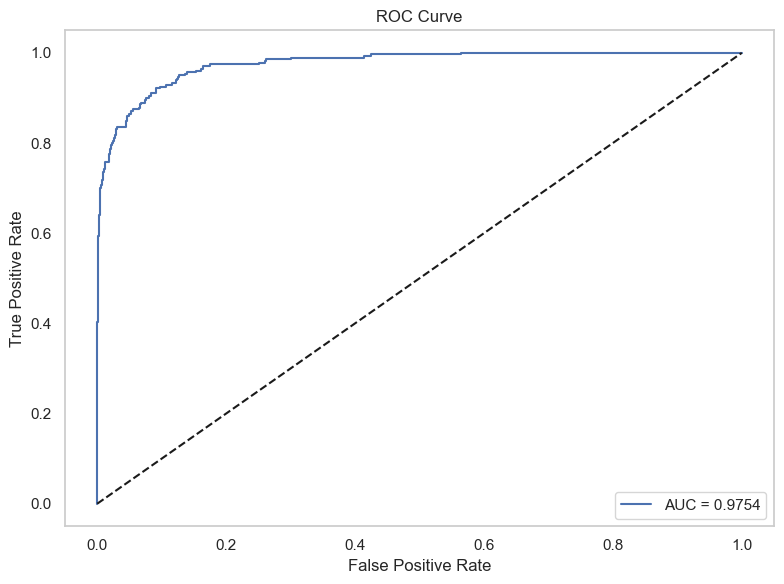

In [69]:
# Get predicted probabilities for the positive class (1)
y_test_proba = log_model.predict_proba(X_test_encoded)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

The logistic regression model demonstrated strong and reliable performance throughout the evaluation process. During validation, it achieved an accuracy of 94% and an AUC-ROC of 0.9787. On the test set, the model remained highly consistent, scoring 91.7% in accuracy and an AUC-ROC of 0.9760.

This close alignment between validation and test results indicates that the model generalizes well and is not overfitting. The minor drop in accuracy is within normal variation and does not suggest any loss in predictive power.

The ROC curve further reinforces the model’s effectiveness. The curve rises sharply and hugs the top-left corner, indicating that the model is excellent at distinguishing between churners and non-churners. With an AUC of 0.9760, the model maintains a high true positive rate while keeping false positives low across a range of thresholds. This shape reflects strong discriminatory performance and confirms that the model consistently separates positive and negative classes with confidence.

Overall, the logistic regression model has proven to be both stable and highly accurate, making it a strong choice for predicting customer churn in this dataset.